# Script to identify which MERRA-2 grid cells are within the Alpine-3D bounding box. The output of the script should look like this. 
```
[INPUT]
VSTATION1 = latlon -65.5 -60.625 0
VSTATION2 = latlon -71 70 0
```

# This script also determines the closest MERRA-2 grid cell to each Alpine-3D grid cell and therefore determines at which MERRA-2 grid cells we need to spinup snow properties.

In [17]:
!pwd

/gpfs/summit/scratch/erke2265/SNOWPACK_WAIS/setup/input_atmospheric_forcing


## Import python packages

In [18]:
import xarray as xr
import numpy as np
from osgeo import osr
from pyproj import Geod
import geopandas as gpd
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

## Define Alpine-3D coordinate corners (see SNOWPACK_WAIS/setup/input_surface_grids/create_input_surface_grids.sh)

/projects/erke2265/miniconda/envs/alpine3d/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


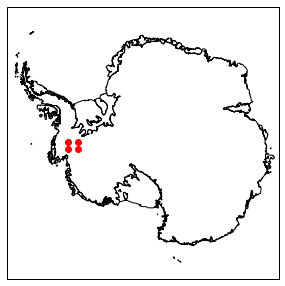

In [19]:
# ncol = 168
# nrow = 107
ncol = 198
nrow = 137

# How far to extend the MERRA-2 domain beyond the Alpine-3D domain. 
bump = 1000 * 50 # m 64 sites
# bump = 1000 * 90 # m 139 sites
# bump = 1000 * 150 # 112

# Define upper left and lower right domain corners in epsg 3031
# left = -1542000 # done
# bottom = -109000 # done
left = -1557000 # done
bottom = -124000 # done

top = bottom + 1000 * (nrow -1)
right = left + 1000 * (ncol -1)


# Plot corners on map
# Coastline Data
df = gpd.read_file("/pl/active/nasa_smb/Data/ADD_Coastline_low_res_polygon.shp")
crs_epsg = ccrs.SouthPolarStereo()
df_epsg = df.to_crs(epsg='3031')

# Map
# Generate figure 
fig, axs = plt.subplots(1, 1, subplot_kw={'projection': crs_epsg},
                        figsize=(5, 5))

# Plot coastlines
axs.set_extent((-180, 180, -90, -65), ccrs.PlateCarree())
axs.add_geometries(df_epsg['geometry'], crs=crs_epsg,
                      facecolor='none', edgecolor='black')

# Plot model domain
plt.scatter(left, bottom, c='r')
plt.scatter(left, top, c='r')
plt.scatter(right, bottom, c='r')
plt.scatter(right, top, c='r')

## Load MERRA-2 lat/lon

In [20]:
# Load lat, lon
ds = xr.open_dataset("/scratch/summit/erke2265/MERRA2/T2M_hourly_1980.nc")
# ds = xr.open_dataset("/pl/active/nasa_smb/MERRA2/yearly_files/T2M_hourly_1980.nc")


grid_lat = ds['lat'].values
grid_lon = ds['lon'].values

# Create lat/lon arrays and reshape into vectors. To undo flatten, np.reshape(grid_lon, [len(ds['lat']), len(ds['lon'])])
grid_lon, grid_lat = np.meshgrid(grid_lon, grid_lat)
grid_lon = grid_lon.flatten()
grid_lat = grid_lat.flatten()

## Convert MERRA-2 lat/lon to epsg 3031

In [21]:
# Source and target EPSG
src = osr.SpatialReference()
tgt = osr.SpatialReference()
src.ImportFromEPSG(4326) # WGS-84
tgt.ImportFromEPSG(3031) # South Polar Stereo

# Define transformation
transform = osr.CoordinateTransformation(src, tgt)

# Initialize arrays
grid_X = np.zeros(len(grid_lon)); grid_X[:] = np.nan
grid_Y = np.zeros(len(grid_lat)); grid_Y[:] = np.nan

# Perform coordinate transformation
for j in range(0, len(grid_X)):
    coords = transform.TransformPoint(grid_lat[j], grid_lon[j])
    grid_X[j], grid_Y[j] = coords[0:2]


## Determine which MERRA-2 grid cell are within the Alpine3D domain

In [22]:
def get_domain(gridX, gridY, left, right, bottom, top, bump):
    right = right + bump
    left = left - bump
    bottom = bottom - bump
    top = top + bump
    
    filter_func = np.vectorize(lambda gridX, gridY: gridX <= right and gridX >= left and gridY >= bottom and gridY <= top)
    
    gridX_filter = gridX[filter_func(gridX, gridY)]
    gridY_filter = gridY[filter_func(gridX, gridY)]
    
    return gridX_filter, gridY_filter

# Call filter function
gridX_filter, gridY_filter = get_domain(grid_X, grid_Y, left, right, bottom, top, bump)

## Convert MERRA-2 coordinates back into regular lat/lon

In [23]:
# Source and target EPSG
src = osr.SpatialReference()
tgt = osr.SpatialReference()
src.ImportFromEPSG(3031) # WGS-84
tgt.ImportFromEPSG(4326) # South Polar Stereo

# Define transformation
transform = osr.CoordinateTransformation(src, tgt)

# Initialize arrays
filter_X_wgs84 = np.zeros(len(gridX_filter)); filter_X_wgs84[:] = np.nan
filter_Y_wgs84 = np.zeros(len(gridY_filter)); filter_Y_wgs84[:] = np.nan

# Perform coordinate transformation
for j in range(0, len(filter_X_wgs84)):
    coords = transform.TransformPoint(gridX_filter[j], gridY_filter[j])
    filter_X_wgs84[j], filter_Y_wgs84[j] = coords[0:2]



## Write station_list.lst

In [24]:
f = open("station_list.lst",'w')
f.write("[INPUTEDITING]\n")

for j in range(0, len(filter_X_wgs84)):
    index = str(j + 1)
    lat = str(round(filter_X_wgs84[j], 3))
    lon = str(round(filter_Y_wgs84[j], 3))
    
    f.write("VSTATION" + index + " = latlon " + lat + " " + lon + " 0\n")
    
f.close()

!cat station_list.lst
!cp station_list.lst ../../snowpack/Scripts/create_smet_from_netcdf

[INPUTEDITING]
VSTATION1 = latlon -77.5 -96.875 0
VSTATION2 = latlon -77.5 -96.25 0
VSTATION3 = latlon -77.5 -95.625 0
VSTATION4 = latlon -77.5 -95.0 0
VSTATION5 = latlon -77.5 -94.375 0
VSTATION6 = latlon -77.5 -93.75 0
VSTATION7 = latlon -77.5 -93.125 0
VSTATION8 = latlon -77.5 -92.5 0
VSTATION9 = latlon -77.5 -91.875 0
VSTATION10 = latlon -77.5 -91.25 0
VSTATION11 = latlon -77.5 -90.625 0
VSTATION12 = latlon -77.5 -90.0 0
VSTATION13 = latlon -77.5 -89.375 0
VSTATION14 = latlon -77.5 -88.75 0
VSTATION15 = latlon -77.5 -88.125 0
VSTATION16 = latlon -77.5 -87.5 0
VSTATION17 = latlon -77.0 -96.875 0
VSTATION18 = latlon -77.0 -96.25 0
VSTATION19 = latlon -77.0 -95.625 0
VSTATION20 = latlon -77.0 -95.0 0
VSTATION21 = latlon -77.0 -94.375 0
VSTATION22 = latlon -77.0 -93.75 0
VSTATION23 = latlon -77.0 -93.125 0
VSTATION24 = latlon -77.0 -92.5 0
VSTATION25 = latlon -77.0 -91.875 0
VSTATION26 = latlon -77.0 -91.25 0
VSTATION27 = latlon -77.0 -90.625 0
VSTATION28 = latlon -77.0 -90.0 0
VSTATIO

## Plot Alpine3D domain and MERRA-2 grid cells

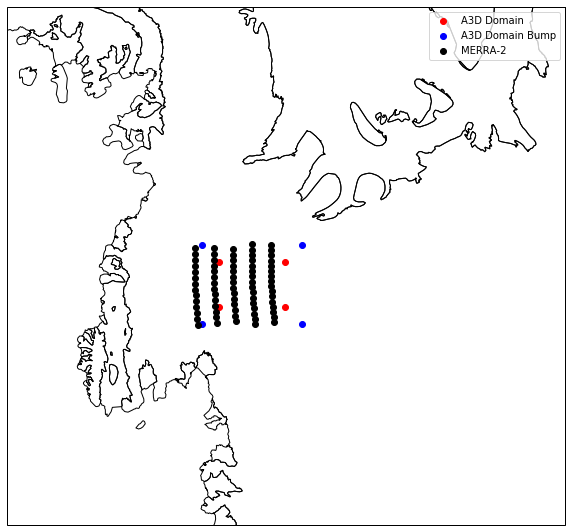

In [25]:
# Map
# Generate figure 
fig, axs = plt.subplots(1, 1, subplot_kw={'projection': crs_epsg},
                        figsize=(10, 10))

# Plot coastlines
# axs.set_extent((-180, 180, -90, -65), ccrs.PlateCarree())
axs.set_extent((-110, -70, -85, -70), ccrs.PlateCarree()) # Zoom in on Alpine-3D domain
axs.add_geometries(df_epsg['geometry'], crs=crs_epsg,
                      facecolor='none', edgecolor='black')

# Plot model domain
plt.scatter(left, bottom, c='r', label="A3D Domain")
plt.scatter(left, top, c='r')
plt.scatter(right, bottom, c='r')
plt.scatter(right, top, c='r')

# Plot model domain dbumped
plt.scatter(left - bump, bottom - bump, c='b', label="A3D Domain Bump")
plt.scatter(left - bump, top + bump, c='b')
plt.scatter(right + bump, bottom - bump, c='b')
plt.scatter(right + bump, top + bump, c='b')

# Plot MERRA-2 grid cells
plt.scatter(filter_Y_wgs84, filter_X_wgs84, transform=ccrs.Geodetic(), c='k', label="MERRA-2")

plt.legend()

# Write a .lus file

49

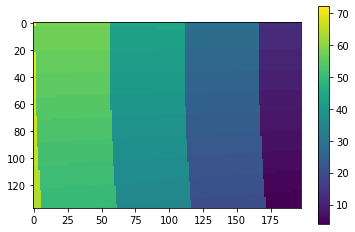

In [26]:
lus = np.zeros([nrow, ncol])
gridX = np.linspace(left, right, ncol) #  ALPINE-3D grid 
gridY = np.linspace(top, bottom, nrow)

# gridX_filter = gridX_filter[0:64]
# gridY_filter = gridY_filter[0:64]

for j in range(0, nrow): # loop over Y
    for k in range(0, ncol): # loop over X
        # For each A3D grid cell, find the index of the closest MERRA-2 grid cell
        A3D_X = gridX[k]
        A3D_Y = gridY[j]
        distance =  np.sqrt(np.power(A3D_X - gridX_filter, 2) + np.power(A3D_Y - gridY_filter, 2))
        lus[j, k] = np.argmin(distance) + 1
        

plt.imshow(lus)
plt.colorbar()

len(np.unique(lus))

In [ ]:
lus.shape

In [ ]:
'''
Start HACK:
Only use previously created smet files for bumped domain. Related to increasing the size of the domain to see how that effects simulations. 
'''

ncol = 198
nrow = 137

# Define upper left and lower right domain corners in epsg 3031
left = -1557500 # done
bottom = -123500 # done

lus = np.pad(lus, 15, mode='edge')

'''
END HACK
'''

lus_int = np.array(lus, dtype=int)

# Define path to write file
fname = "../../input/surface-grids/dem.lus"
# fname = "/scratch/summit/erke2265/dem.lus"



# Open file
f = open(fname,'w')
f.write("ncols        " + str(ncol) + "\n")
f.write("nrows        " + str(nrow) + "\n")
f.write("xllcorner        " + str(left) + "\n")
f.write("yllcorner        " + str(bottom) + "\n")
f.write("cellsize     1000.000000000000\n")
f.write("NODATA_value  -9999\n")

# Write individual data lines
for j in range(0, lus.shape[0]):
    line = np.array2string(lus_int[j,:], max_line_width=99999)
    line = line[1:-1]
    f.write(line + "\n")

# Close file
f.close()

# !cat ../../input/surface-grids/dem.lus
# !cat /scratch/summit/erke2265/dem.lus

## Write TSG grid

In [ ]:
# Source and target EPSG
src = osr.SpatialReference()
tgt = osr.SpatialReference()
src.ImportFromEPSG(3031) # WGS-84
tgt.ImportFromEPSG(4326) # South Polar Stereo

# Define transformation
transform = osr.CoordinateTransformation(src, tgt)

# TS_mean file
TS_mean = xr.open_dataset("/pl/active/nasa_smb/MERRA2/yearly_files/TS_mean_1980_2017.nc")
TS_mean = TS_mean['TS'][0,:,:]

# Define path to write file
fname = "../../input/surface-grids/TSG.asc"
# fname = "/scratch/summit/erke2265//TSG.asc"

gridX = np.arange(left, left + 1000 * ncol, 1000)
gridY = np.arange(bottom + 1000 * nrow, bottom, -1000)
# gridY = np.arange(bottom, bottom + 1000 * ncol, 1000)



# Open file
f = open(fname,'w')
f.write("ncols        " + str(ncol) + "\n")
f.write("nrows        " + str(nrow) + "\n")
f.write("xllcorner        " + str(left) + "\n")
f.write("yllcorner        " + str(bottom) + "\n")
f.write("cellsize     1000.000000000000\n")
f.write("NODATA_value  -9999\n")

# Loop over eachcell and find the closest TS_mean grid cell
for j in range(0, nrow):
    for k in range(0, ncol):
        coords = transform.TransformPoint(float(gridX[k]), float(gridY[j]))
        A3D_lat, A3D_lon = coords[0:2]
        # This next line is slow, but could be sped up by setting A3D_lat and A3D_lon to contain all grid cells
        # instead of one at a time. 
        TSG_ind = float(TS_mean.sel(lat=A3D_lat, lon=A3D_lon, method='nearest').values)
        
        f.write(str(TSG_ind) + " ") # Write the closest TS_mean and a space
    f.write("\n")

# Close file
f.close()

## Write to_exec.lst file for each unique MERRA-2 grid cell 

In [ ]:
# Define path to write file
fname = "../../spinup/to_exec.lst"

# Open file
f = open(fname,'w')

for j in range(0, len(np.unique(lus))):
    f.write("bash run.sh site_" + str(int(np.unique(lus)[j])) + "\n")
    
f.close()

!cat ../../spinup/to_exec.lst